# LinearRegression и LogisticRegression

Реализовать 2 класса LinearRegression и LogisticRegression

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score
%matplotlib inline
from sklearn.model_selection import KFold

In [3]:
def countStat(x, y, clf, n=5, decision_threshold=0.0):
    
    gkf = KFold(n_splits=n, shuffle=True)
    
    print ("| %20s | %20s | %20s |" % ("accuracy", "recall", "precision"))

    for train, test in gkf.split(x, y):
        X_train, y_train = x[train], y[train]
        X_test, y_test = x[test], y[test]

        clf.fit(X_train, y_train)

        pr_raw = clf.predict(X_test)
        
        pr = np.around(pr_raw + decision_threshold)

        accuracy = accuracy_score(y_pred=pr, y_true=y_test)
        recall = recall_score(y_test, pr)
        precision = precision_score(y_test, pr)

        print ("| %20f | %20f | %20f |" % (accuracy, recall, precision))

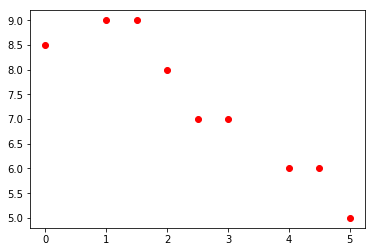

In [89]:
X = np.array([0, 1, 2, 3, 4, 5, 1.5, 2.5, 4.5])
Y = np.array([8.5, 9, 8, 7, 6, 5,   9,   7,   6])

plt.figure(1)
plt.plot(X, Y, marker='o', color='red', ls='')
plt.show()

In [222]:
class LinearRegression():
    
    def __init__(self, step_size=1, change_step=True, max_iter=100, eps=0.01, pi=100):
        self.step_size = step_size
        self.max_iter = max_iter
        self.change_step = change_step
        self.eps = eps
        self.pi = pi
        self.w = None
        self.iter = 0
        
    def fit(self, x, y):
        
        if (len(x.shape) == 1):
            d = 2
        else:
            d = x.shape[1]  # Количество измерений (атрибутов)
        
        work = True
        n = x.shape[0]      # Количество элементов (точек)
        u = self.step_size  # Коэффициент шага (переменный)
        t = 0               # Номер итерации
        
        w = np.array([0 for _ in range(d)]) # Веса
        
        while (work):
            t += 1
            if (self.change_step):
                u = self.step_size / t
            
            #gQ = (2/n) * np.dot(np.transpose(x), (np.dot(x, w) - y)) # Градиент от Q
            
            dQdw1 = 0.0
            dQdw0 = 0.0
            for i in range(n):
                dQdw1 += x[i]*(x[i]*w[1] - y[i] + w[0])
                dQdw0 += (x[i]*w[1] - y[i] + w[0])
            
            dQdw1 = 2/float(n) * dQdw1
            dQdw0 = 2/float(n) * dQdw0
            
            gQ = np.array([dQdw0, dQdw1])
            
            w = w - u * gQ
            
            work = (t <= self.max_iter and np.any(np.absolute(u * gQ) >= self.eps))
            
            if (t % self.pi == 0 or t == 1):
                plt.figure(1)
                plt.plot(x, y, marker='o', color='red', ls='')
                plt.plot(x, w[1]*x + w[0], color='blue')
                plt.show()
            
        self.iter = t
        print t
        self.w = w
        return self
    
    def predict(self, x):
        return self.w[1]*x + self.w[0]

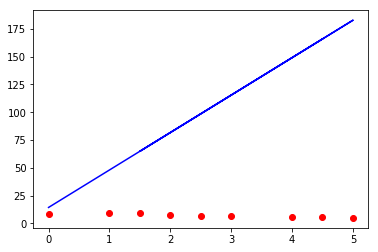

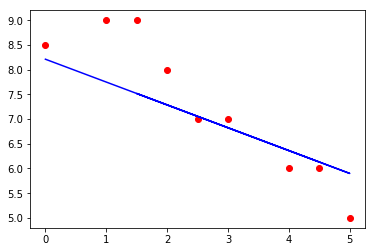

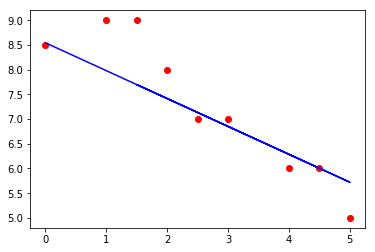

41


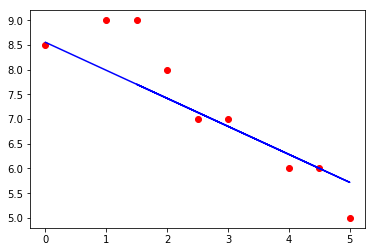

In [223]:
clf = LinearRegression(step_size=0.99, change_step=True, max_iter=3000, eps=0.01, pi=20)
clf.fit(X, Y)
pr = clf.predict(X)

plt.figure(1)
plt.plot(X, Y, marker='o', color='red', ls='')
plt.plot(X, pr, color='blue')
plt.show()

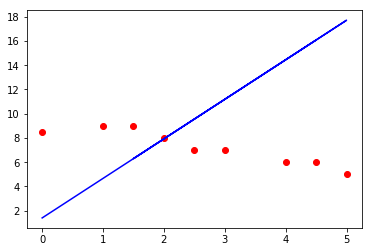

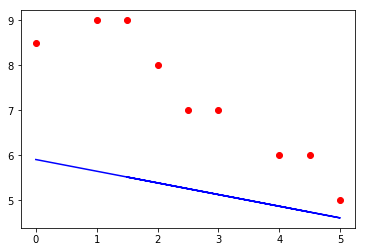

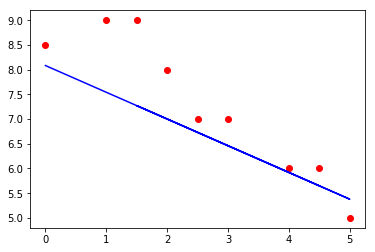

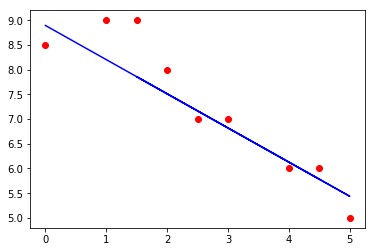

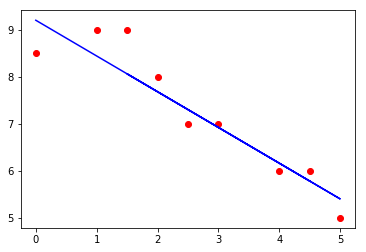

85


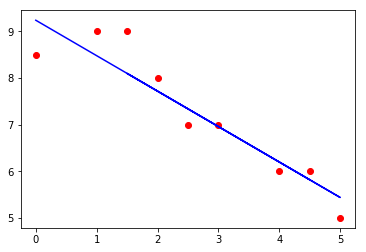

In [224]:
clf = LinearRegression(step_size=0.096, change_step=False, max_iter=1000, eps=0.01, pi=20)
clf.fit(X, Y)
pr = clf.predict(X)

plt.figure(1)
plt.plot(X, Y, marker='o', color='red', ls='')
plt.plot(X, pr, color='blue')
plt.show()

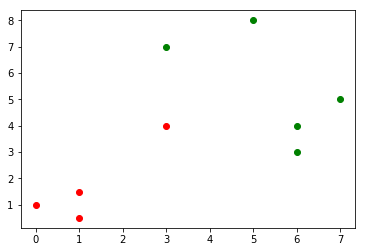

In [228]:
X = np.array([[0, 1], [1, 1.5], [1, 0.5], [6, 3], [3, 4], [5, 8], [6, 4], [7, 5], [3, 7]])
Y = np.array([     0,        0,        0,      1,      0,      1,      1,      1,      1])

plt.figure(1)
for i in range(X.shape[0]):
    clr = 'green'
    if (Y[i] == 0):
        clr = 'red'
    plt.plot(X[i][0], X[i][1], marker='o', color=clr, ls='')
plt.show()

In [225]:
def sigm(x):
    return 1/(1+e**(-x))

class LogisticRegression():
    
    def __init__(self, step_size=1, change_step=True, max_iter=100, eps=0.01, pi=100):
        self.step_size = step_size
        self.max_iter = max_iter
        self.change_step = change_step
        self.eps = eps
        self.pi = pi
        self.w = None
        self.iter = 0
        
    def fit(self, x, y):
        
        work = True
        d = x.shape[1]      # Количество измерений (атрибутов)
        n = x.shape[0]      # Количество элементов (точек)
        u = self.step_size  # Коэффициент шага (переменный)
        t = 0               # Номер итерации
        
        w = np.array([0 for _ in range(d)]) # Веса
        
        while (work):
            t += 1
            if (self.change_step):
                u = self.step_size / t
                
            z = sum(np.dot(x, w))
            
            gQ
            
            gQ = np.array([dQdw0, dQdw1])
            
            w = w - u * gQ
            
            work = (t <= self.max_iter and np.any(np.absolute(u * gQ) >= self.eps))
            
            if (t % self.pi == 0 or t == 1):
                plt.figure(1)
                plt.plot(x, y, marker='o', color='red', ls='')
                plt.plot(x, w[1]*x + w[0], color='blue')
                plt.show()
            
        self.iter = t
        print t
        self.w = w
        return self
    
    def predict(self, x):
        return self.w[1]*x + self.w[0]

SyntaxError: invalid syntax (<ipython-input-225-0abdda566e23>, line 39)